<a href="https://colab.research.google.com/github/KyleRoss-rice/tiny-cifar10-experiments/blob/main/challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_pretrained_vit
!wget https://raw.githubusercontent.com/davda54/sam/main/sam.py

--2021-04-28 03:37:24--  https://raw.githubusercontent.com/davda54/sam/main/sam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2126 (2.1K) [text/plain]
Saving to: ‘sam.py.2’

sam.py.2            100%[===================>]   2.08K  --.-KB/s    in 0s      

2021-04-28 03:37:24 (38.4 MB/s) - ‘sam.py.2’ saved [2126/2126]



In [ ]:
! git clone https://github.com/moskomule/senet.pytorch
%cd /content/senet.pytorch/senet

fatal: destination path 'senet.pytorch' already exists and is not an empty directory.
/content/senet.pytorch/senet


In [ ]:
import torchvision
import torchvision.models as models
from torchvision import transforms,datasets

from pytorch_pretrained_vit import ViT

from numpy.random import RandomState
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import Subset
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.hub

from copy import deepcopy

from sam import SAM

import matplotlib.pyplot as plt

import time as timer

# Useful functions to do data augmentation

In [ ]:
class augmentation(object):   # A class that does augmentations (horizontal an vertical flipping, random prespective, and rotation) on the passed images
  def __init__(self):
    
    self.horizontal_flip = torchvision.transforms.RandomHorizontalFlip(p=1)
    self.vertical_flip =torchvision.transforms.RandomVerticalFlip(p=1)
    self.distortion = torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=1)
    
    
  def forward(self,img,label):
    """ 
    Args:
        img: Pass images to be augmented using classical augmentations such as horizontal an vertical flipping, random prespective, and rotation
        label: Pass the labels to be increased according to the number of augmentations
    Returns: a classically augmented data set with the corresponding labels
        - augmentations: A torch tensor 
    Shape: 
        - img: any image shape
        - augmentations is 5x the batch size of the input img similarly for the targets
    """
    n, c, h, w = img.shape
    augmentations = torch.empty((n*5, c,h,w),dtype=torch.float32)
    targets = torch.empty(n*5,dtype=torch.long)
    for t in range(0,n*5,n):
      targets[t:t+n] = label
    
    augmentations [0:n] = self.horizontal_flip(img)
    augmentations [n:2*n] = self.vertical_flip(img)
    augmentations [2*n:3*n] = self.distortion(img)
    augmentations [3*n:4*n] = torchvision.transforms.functional.rotate(img, 10)
    augmentations [4*n:5*n] = img 
    return augmentations, targets

In [ ]:
def mixup_data(x, y, device):                                                   # Implements Mixup augmentation from https://arxiv.org/pdf/1710.09412.pdf
    '''Returns mixed inputs, pairs of targets, and lambda'''
  
    lam = np.random.beta(1.0, 1.0)
    

    batch_size = x.size()[0]
   
    index = torch.randperm(batch_size).to(device)
    

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):                            # Training loss criteria for Mixup 
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
def ricap(images, targets,beta,device):                                         # Implements RICAP augmentation technique from https://arxiv.org/pdf/1811.09030.pdf
  """ Images: the images to be augmented using RICAP
      targets: the corresponding targets of the images
      Beta: A hyperparameter used (refer back to the paper for details)
      device: CPU or GPU device
  """

  # size of image
  I_x, I_y = images.size()[2:]

  # generate boundary position (w, h)
  w = int(np.round(I_x * np.random.beta(beta, beta)))
  h = int(np.round(I_y * np.random.beta(beta, beta)))
  w_ = [w, I_x - w, w, I_x - w]
  h_ = [h, h, I_y - h, I_y - h]

  # select four images
  cropped_images = {}
  c_ = {}
  W_ = {}
  for k in range(4):
      index = torch.randperm(images.size(0)).to(device)
      x_k = np.random.randint(0, I_x - w_[k] + 1)
      y_k = np.random.randint(0, I_y - h_[k] + 1)
      cropped_images[k] = images[index][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
      c_[k] = targets[index]
      W_[k] = (w_[k] * h_[k]) / (I_x * I_y)

  # patch cropped images
  patched_images = torch.cat(
      (torch.cat((cropped_images[0], cropped_images[1]), 2),
        torch.cat((cropped_images[2], cropped_images[3]), 2)),
      3)

  targets = (c_, W_)
  return patched_images, targets

def ricap_criterion(outputs, targets):                                          # Training loss criteria for RICAP
  c_, W_ = targets
  loss = sum([W_[k] * F.cross_entropy(outputs, Variable(c_[k])) for k in range(4)])
  return loss

# Training and testing functions

In [ ]:
def train(model, device, train_loader, optimizer, epoch,mode,ricap_beta, SAM,display=True):
  """ Args:
      model: the model to be trained
      device: CPU or GPU device
      train_loader: loader for the training data
      optimizer: torch.optim.Adam, torch.optim.SGD, etc...
      epoch: current epoch number
      ricap_beta: a hyperparameter used with RICAP augmentations 
      SAM: True -- if SAM is to be used for optimization
  """
  correct =0
  model.train()                                                                 # set the model to training mode for techniques such as batchnorm
  criterion = nn.CrossEntropyLoss()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)                         # Moving data to the chosen device (no augmentations)
      original_data, original_targets = deepcopy(data).to(device),deepcopy(target).to(device)
      if mode =='mixup':                                                        # If the chosen augmentation mode is "Mixup"
        data, targets_a, targets_b, lam = mixup_data(data, target,device)
        data, targets_a, targets_b = map(Variable, (data,targets_a, targets_b))
      elif mode == 'ricap':                                                     # If the chosen augmentation mode is "RICAP"
        data, target = ricap(data,target,ricap_beta,device)                     # Beta is a hyperparameter and is chosen to be 0.05 in our experiments
      elif mode == 'augment':                                                   # If the chosen augmentation mode is classical augmentations 
        augment = augmentation()                                             
        data, target = augment.forward(data,target) 
        data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      
      
      def closure():                                                            #Needed by Sharpness Aware Minimization (SAM) optimizer to reevaluate the model                            
        if mode =='mixup':                                                    
          loss = mixup_criterion(criterion, model(data), targets_a, targets_b, lam)
        elif mode == 'ricap':
          loss = ricap_criterion(model(data),target)
        else:                                                
          loss = F.cross_entropy(model(data),target)
        
        loss.backward()
        return loss
        
      
      if mode == 'mixup':
        loss = mixup_criterion(criterion, model(data), targets_a, targets_b, lam)
      elif mode == 'ricap':
        loss = ricap_criterion(model(data),target)
      else:                                                  
        loss = F.cross_entropy(model(data),target)
      
      loss.backward()
      if SAM == True :
        optimizer.step(closure)
      else: 
        optimizer.step()

      pred = model(original_data).max(1, keepdim=True)[1]                       # get the index of the max log-probability
      correct += pred.eq(original_targets.view_as(pred)).sum().item()
      
  if display:
        print(f"Train Epoch: {epoch} [{epoch}/100 ({epoch}%)]     Loss: {loss:.5f}")
  return loss , correct/len(train_loader.dataset)                               # returns loss and accuracy each epoch

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item()# sum up batch loss
            pred = output.max(1, keepdim=True)[1]                               # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# The models

In [ ]:
schemes = ["VGG16","GoogleNet","ViT","ResNext50","SE-ResNet50"]
trained_models ={
"VGG16" : models.vgg16(pretrained=True),
"GoogleNet" : models.googlenet(pretrained=True),
"ViT": ViT('B_32', pretrained=True),
"ResNext50": models.resnext50_32x4d(pretrained=True),
"SE-ResNet50" :  torch.hub.load('moskomule/senet.pytorch','se_resnet50',pretrained=True,)
}

Loaded pretrained weights.


Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


Changing the last layer to fit the number of classes in CIFAR-10

In [ ]:
trained_models["VGG16"].classifier[6]= nn.Linear(4096,10)
trained_models["GoogleNet"].fc= nn.Linear(1024,10)
trained_models["ViT"].fc = nn.Linear(768, 10)
trained_models["ResNext50"].fc= nn.Linear(2048,10)
trained_models["SE-ResNet50"].fc= nn.Linear(2048,10)
for m in trained_models:
  trained_models[m].eval()                                                      # we can simply set the entire network to eval, since we are only training the final FC layer, without dropout or batchnorm
  for param in trained_models[m].parameters():                                  # Setting all parameters to require_grad=False to avoid memory issues
    param.requires_grad= False
  if m == "VGG16":
    trained_models[m].classifier.train()
    for p in trained_models[m].classifier.parameters():                         # Only setting the parameters of the last layer to require gradients
      p.requires_grad=True
  else:
    trained_models[m].fc.train()
    for p in trained_models[m].fc.parameters():
      p.requires_grad=True

# The data

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# We resize images to allow using imagenet pre-trained models
resize = transforms.Resize((224)) 

transform_val = transforms.Compose([resize, transforms.ToTensor(), normalize]) 
transform_train = transforms.Compose([resize, transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device) 
    
##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)

# Final evaluation will be from the CIFAR-10 test data 
cifar_data_tst = datasets.CIFAR10(root='.',train=False, transform=transform_val, download=True)

cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# The training and testing

In [ ]:

learning_rate = 0.01

accs = {new_list:[] for new_list in range(len(trained_models))}
final_accs=  {new_list:[] for new_list in range(len(trained_models))}
for seed in [1,2,3]:
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 5000))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:10]] for classe in range(0, 10)]) # Extract a subset of 100 (class balanced) samples per class
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[10:210]] for classe in range(0, 10)]) # Extract a subset of 2000 (class balanced) samples per class for validation
  random_permute = prng.permutation(np.arange(0, 900))
  indx_tst = np.concatenate([np.where(np.array(cifar_data_tst.targets) == classe)[0][random_permute[0:200]] for classe in range(0, 10)]) # The final test will be done on a subset of 2000 samples from CIFAR-10 testing data 
  
  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)                                   # Test set I 
  tst_data = Subset(cifar_data_tst,indx_tst)                                    # Test set II
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=256, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  tst_loader = torch.utils.data.DataLoader(tst_data,
                                           batch_size=128, 
                                           shuffle=False)
  
  ctr =0
  if seed == 1 :
    train_losses = {new_list:[] for new_list in range(len(trained_models))}
    train_acc ={new_list:[] for new_list in range(len(trained_models))}
    runtime_train= {new_list:[] for new_list in range(len(trained_models))}
    runtime_test =  {new_list:[] for new_list in range(len(trained_models))}
  for model in trained_models:
    b_optimizer = torch.optim.Adam
    # use SAM + Adam
    if model == "VGG16":
      optimizer = SAM(trained_models[model].classifier.parameters(), b_optimizer, lr=learning_rate)
      #optimizer = b_optimizer(trained_models[model].classifier.parameters(),lr=learning_rate)
    else:
      optimizer = SAM(trained_models[model].fc.parameters(), b_optimizer, lr=learning_rate)
      #optimizer = b_optimizer(trained_models[model].fc.parameters(),lr=learning_rate)

    
    trained_models[model].to(device)
    if seed ==1 :
      start = timer.time()
    print(f"Training the last layer of {model} in progress..")
    for epoch in range(10):
      
      loss, acc = train(trained_models[model], device, train_loader, optimizer, epoch,mode="None",ricap_beta=0.05,SAM=True, display=True)
      if seed == 1:
        train_losses[ctr].append(loss)
        train_acc[ctr].append(acc)
    print(f"Successfully trained the last layer of {model}")
    if seed == 1:
      end = timer.time() - start
      runtime_train[ctr].append(end)
      print(f"Training of {model} took {end:.2f} seconds")
      start = timer.time()
    print(f"Testing on test set I (2000 samples from CIFAR-10 training data)")
    accs[ctr].append(test(trained_models[model], device, val_loader))
    print(f"Testing on test set II (2000 samples from CIFAR-10 testing data")
    final_accs[ctr].append(test(trained_models[model], device, tst_loader))
    if seed ==1:
      runtime_test[ctr].append(timer.time()-start)
    ctr = ctr +1
for s in range(len(schemes)):
  accs[s] = np.array(accs[s])
  final_accs[s] =np.array(final_accs[s])
  print(f"Acc over 3 instances of test set I for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}")
  print(f"Acc over 3 instances of test set II for {schemes[s]} is: {final_accs[s].mean():.3f} +- {final_accs[s].std():.3f}")

Training the last layer of VGG16 in progress..
Train Epoch: 0 [0/100 (0%)]     Loss: 2.39964
Train Epoch: 1 [1/100 (1%)]     Loss: 250.27602
Train Epoch: 2 [2/100 (2%)]     Loss: 388.92886
Train Epoch: 3 [3/100 (3%)]     Loss: 270.68262
Train Epoch: 4 [4/100 (4%)]     Loss: 91.11820
Train Epoch: 5 [5/100 (5%)]     Loss: 16.33701
Train Epoch: 6 [6/100 (6%)]     Loss: 13.37305
Train Epoch: 7 [7/100 (7%)]     Loss: 4.69449
Train Epoch: 8 [8/100 (8%)]     Loss: 0.83945
Train Epoch: 9 [9/100 (9%)]     Loss: 0.37583
Successfully trained the last layer of VGG16
Training of VGG16 took 16.61 seconds
Testing on test set I (2000 samples from CIFAR-10 training data)

Test set: Average loss: 63.3834, Accuracy: 419/2000 (20.95%)

Testing on test set II (2000 samples from CIFAR-10 testing data

Test set: Average loss: 63.1355, Accuracy: 404/2000 (20.20%)

Training the last layer of GoogleNet in progress..
Train Epoch: 0 [0/100 (0%)]     Loss: 2.34645
Train Epoch: 1 [1/100 (1%)]     Loss: 2.88972
Trai

# Results

## SAM + Adam at an lr of 0.001 with Mixup augmentations 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

Acc over 3 instances for VGG16 is: 53.783 +- 13.183%
Acc over 3 instances for GoogleNet is: 55.083 +- 9.121%
Acc over 3 instances for ViT is: 83.983 +- 4.988%
Acc over 3 instances for ResNext50 is: 52.500 +- 9.240%
Acc over 3 instances for SE-ResNet50 is: 60.133 +- 6.262%


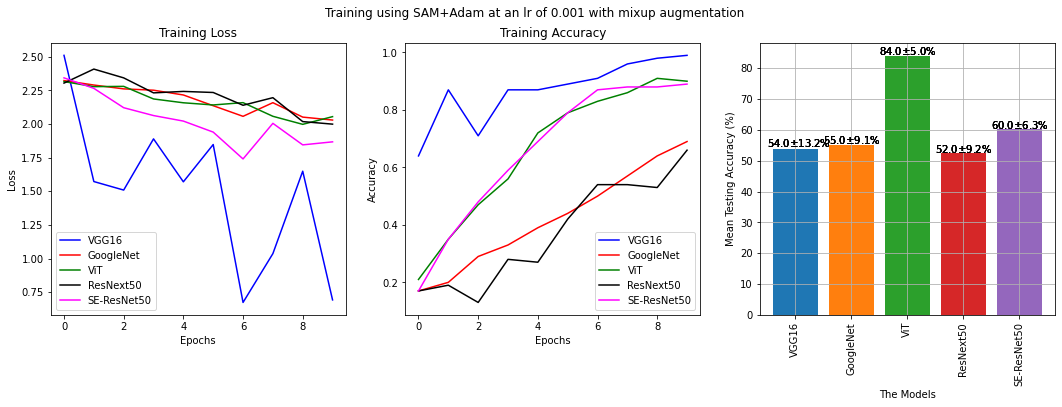

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adam at an lr of {learning_rate} with mixup augmentation ")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  #plt.ylim((0.0,20.0))
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

## SAM + Adam lr =0.001 with RICAP beta = 0.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

Acc over 3 instances for VGG16 is: 47.417 +- 12.569%
Acc over 3 instances for GoogleNet is: 61.100 +- 5.843%
Acc over 3 instances for ViT is: 83.917 +- 4.999%
Acc over 3 instances for ResNext50 is: 61.783 +- 4.761%
Acc over 3 instances for SE-ResNet50 is: 58.300 +- 4.081%


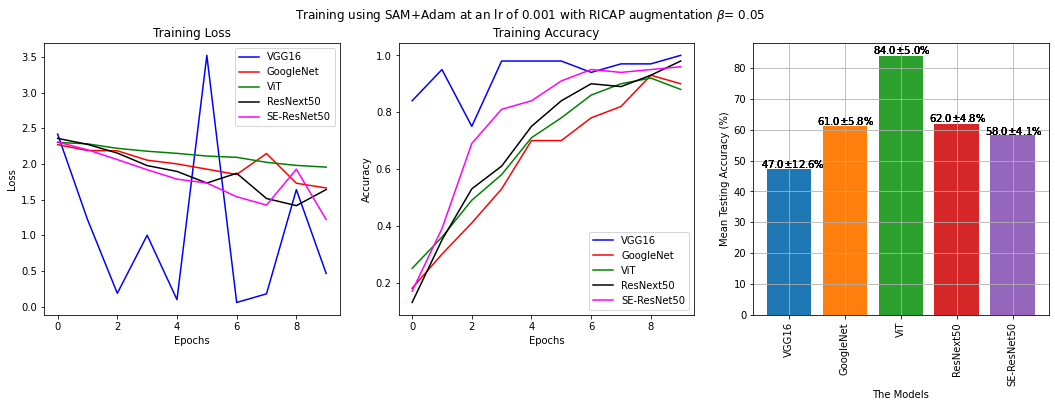

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adam at an lr of {learning_rate} with RICAP augmentation " +r"$\beta$= 0.05")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  #plt.ylim((0.0,20.0))
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

## SGD lr=0.001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

Acc over 3 instances for VGG16 is: 48.400 +- 7.938%
Acc over 3 instances for GoogleNet is: 13.933 +- 2.589%
Acc over 3 instances for ViT is: 18.050 +- 1.246%
Acc over 3 instances for ResNext50 is: 16.783 +- 3.371%
Acc over 3 instances for SE-ResNet50 is: 19.667 +- 3.225%


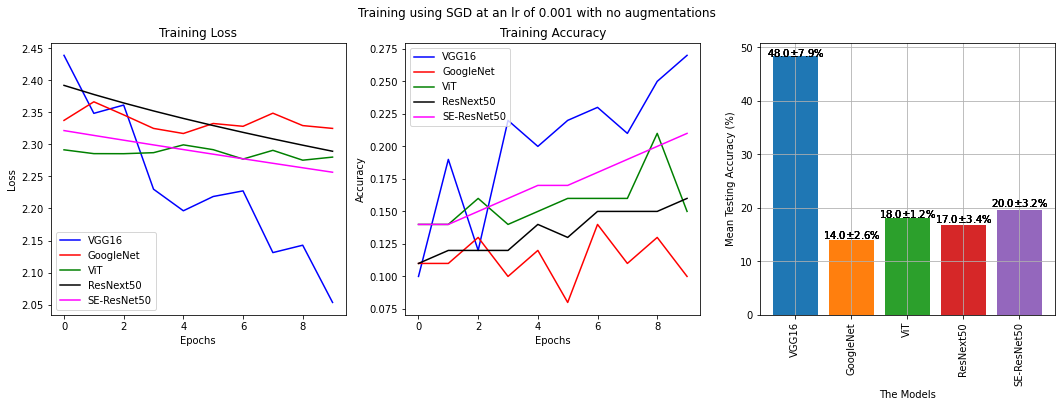

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SGD at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.15,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


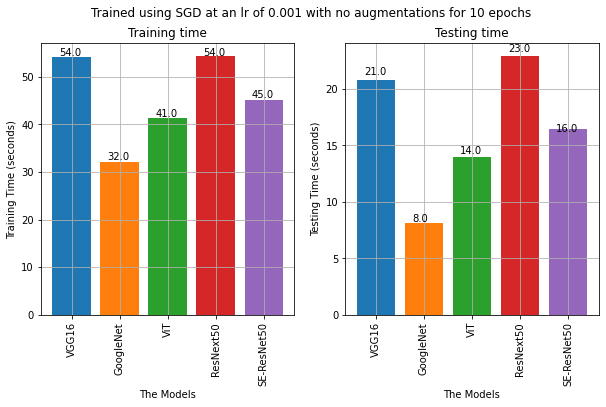

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SGD at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.text(t-0.25,np.round(runtime_test[t])+0.25,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.xticks(rotation="vertical")
  plt.grid(True)

## Adam lr= 0.001 and no augmentations


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

Acc over 3 instances for VGG16 is: 49.433 +- 5.329%
Acc over 3 instances for GoogleNet is: 60.283 +- 7.578%
Acc over 3 instances for ViT is: 84.133 +- 5.709%
Acc over 3 instances for ResNext50 is: 66.983 +- 4.584%
Acc over 3 instances for SE-ResNet50 is: 63.317 +- 4.055%


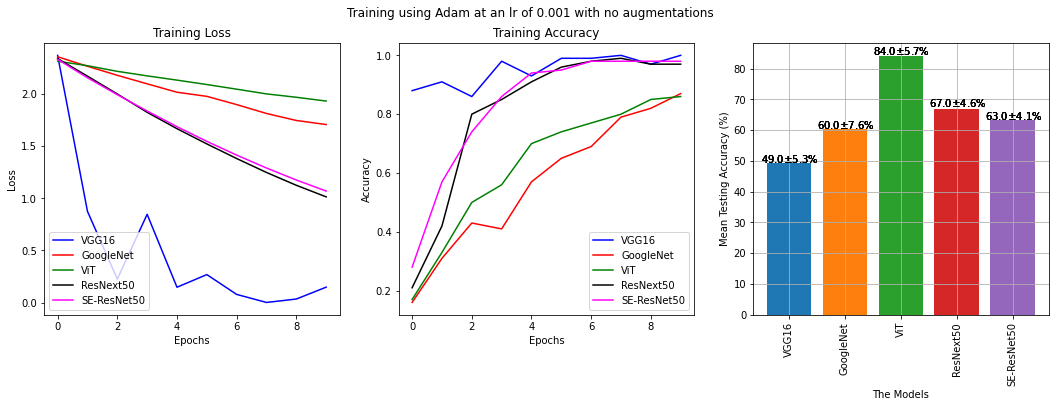

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using Adam at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


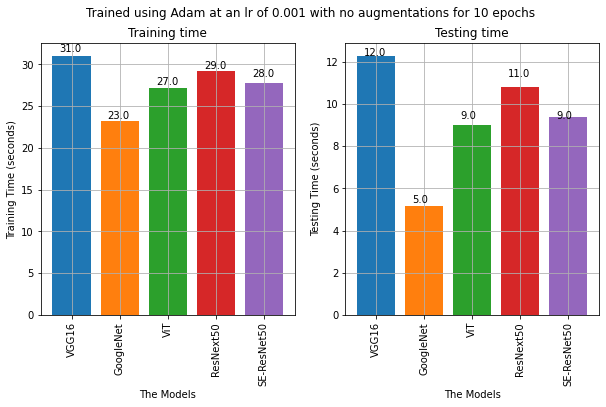

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using Adam at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.text(t-0.25,np.round(runtime_test[t])+0.3,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.xticks(rotation="vertical")
  plt.grid(True)

## SAM+Adam lr=0.01 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

Acc over 3 instances for VGG16 is: 46.100 +- 12.223%
Acc over 3 instances for GoogleNet is: 49.533 +- 9.897%
Acc over 3 instances for ViT is: 88.783 +- 0.811%
Acc over 3 instances for ResNext50 is: 35.067 +- 3.830%
Acc over 3 instances for SE-ResNet50 is: 44.333 +- 6.903%


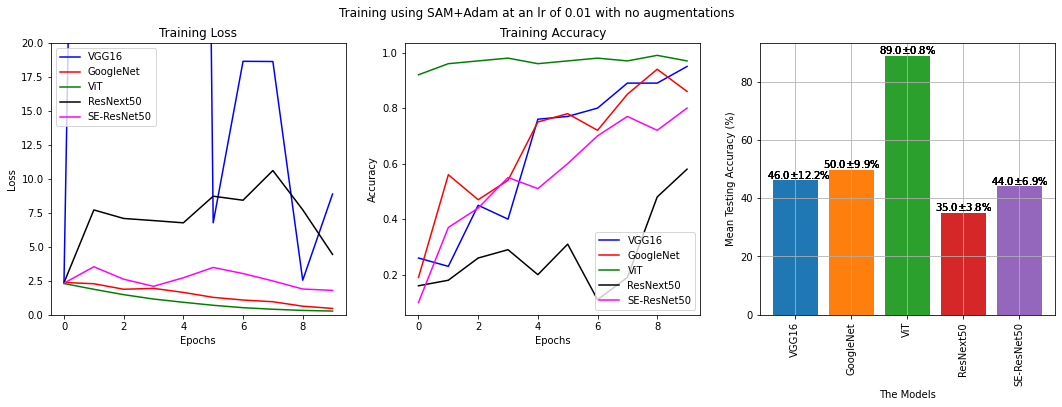

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adam at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.ylim((0.0,20.0))
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


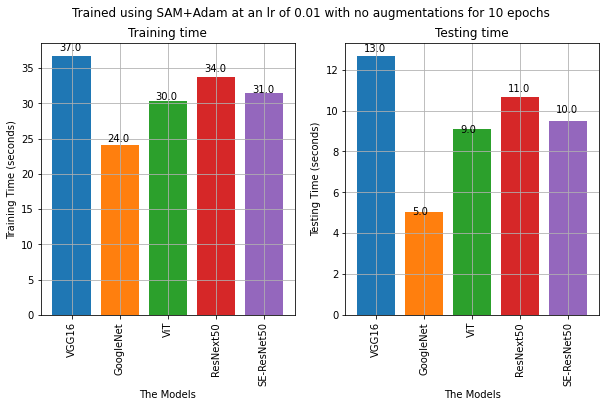

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+Adam at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_test[t])-0.1,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.grid(True)

## SAM + Adadelta lr =0.001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

Acc over 3 instances for VGG16 is: 11.250 +- 1.122%
Acc over 3 instances for GoogleNet is: 9.050 +- 0.356%
Acc over 3 instances for ViT is: 8.367 +- 0.184%
Acc over 3 instances for ResNext50 is: 8.633 +- 0.556%
Acc over 3 instances for SE-ResNet50 is: 14.083 +- 0.703%


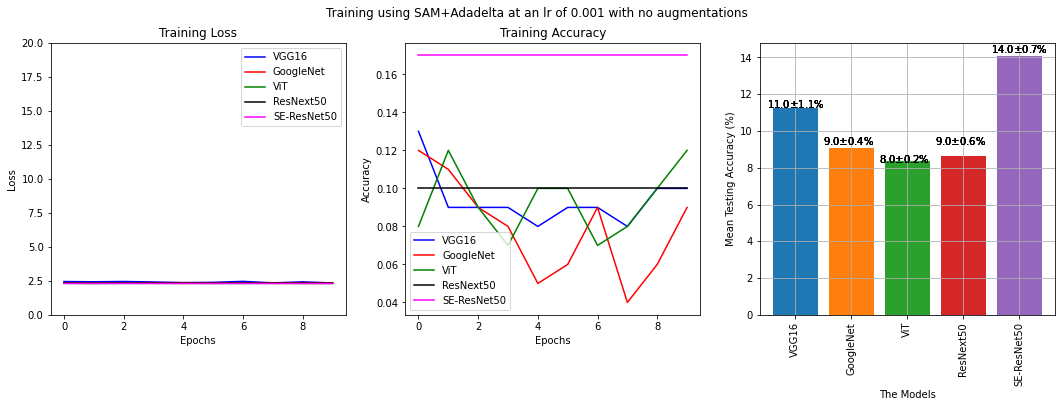

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adadelta at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.ylim((0,20.0))
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.25,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


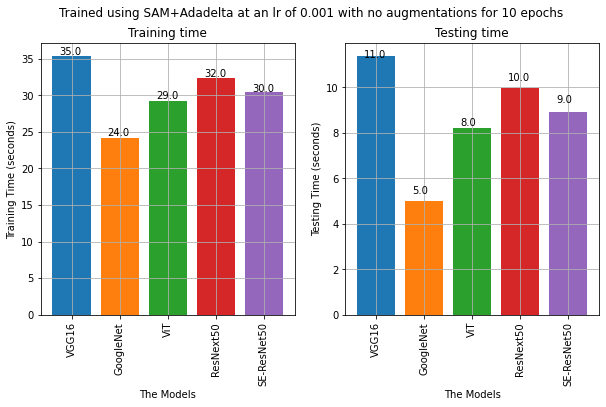

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+Adadelta at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_test[t])+0.3,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.grid(True)

## SAM + RMSprop lr=0.001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

Acc over 3 instances for VGG16 is: 48.417 +- 16.978%
Acc over 3 instances for GoogleNet is: 64.617 +- 1.952%
Acc over 3 instances for ViT is: 89.117 +- 1.052%
Acc over 3 instances for ResNext50 is: 56.667 +- 6.430%
Acc over 3 instances for SE-ResNet50 is: 60.617 +- 3.430%


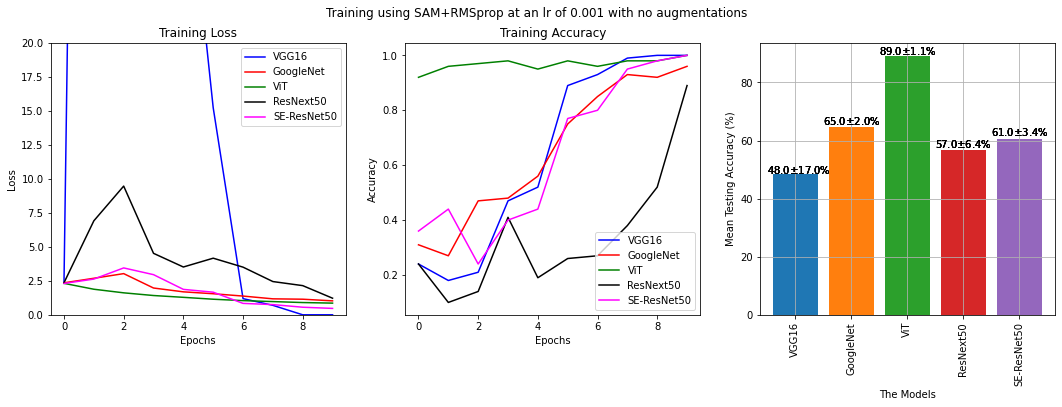

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+RMSprop at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.ylim((0,20.0))
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


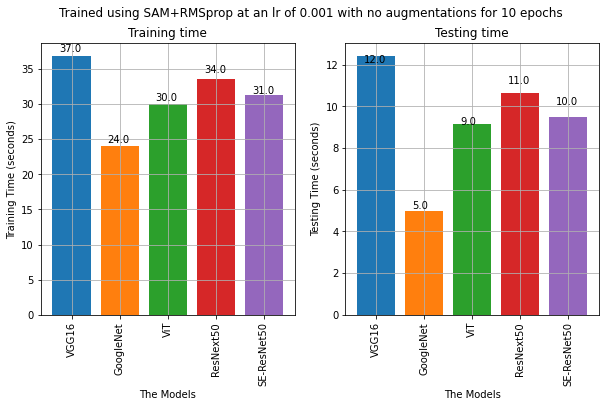

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+RMSprop at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_test[t])+0.1,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.grid(True)

## SAM+ Adam lr= 0.001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

Acc over 3 instances for VGG16 is: 54.833 +- 5.776%
Acc over 3 instances for GoogleNet is: 60.667 +- 6.285%
Acc over 3 instances for ViT is: 83.467 +- 5.078%
Acc over 3 instances for ResNext50 is: 61.150 +- 6.534%
Acc over 3 instances for SE-ResNet50 is: 63.050 +- 4.399%


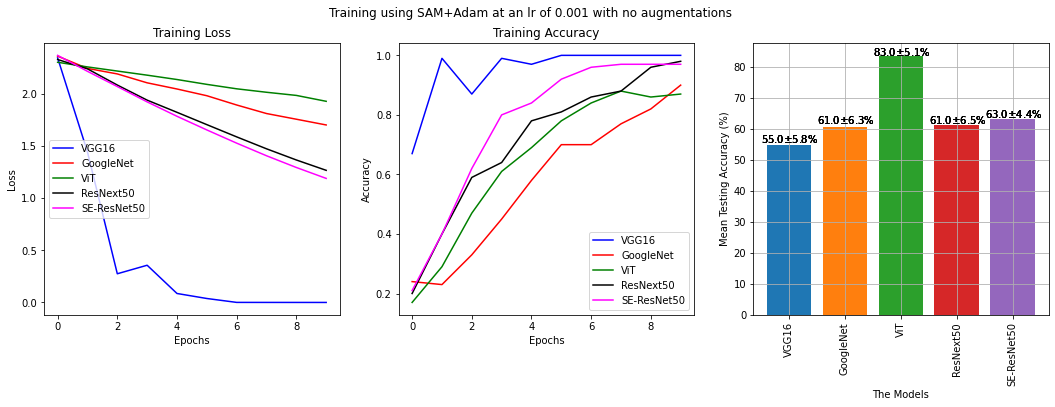

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adam at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


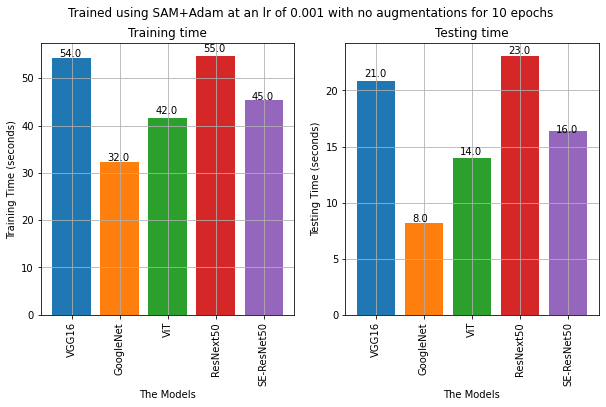

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+Adam at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_test[t])+0.25,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.grid(True)

## SAM+ ADAM lr = 0.0001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

Acc over 3 instances for VGG16 is: 68.750 +- 3.142%
Acc over 3 instances for GoogleNet is: 20.300 +- 6.668%
Acc over 3 instances for ViT is: 28.383 +- 10.731%
Acc over 3 instances for ResNext50 is: 34.683 +- 9.229%
Acc over 3 instances for SE-ResNet50 is: 31.883 +- 10.380%


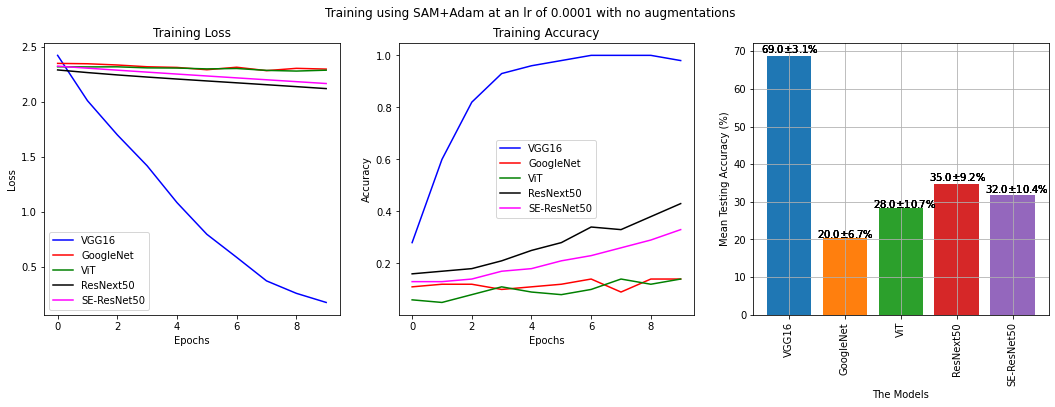

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(18,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+Adam at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.5,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


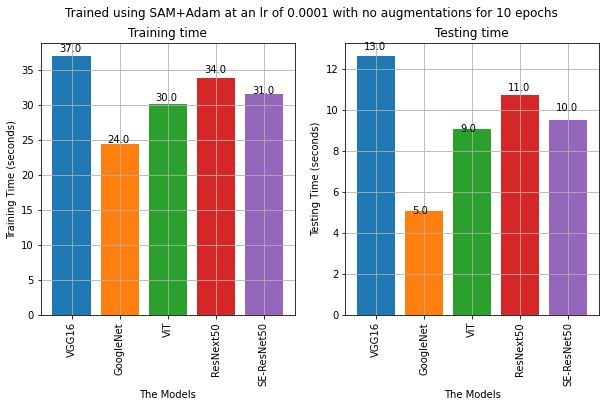

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+Adam at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.text(t-0.25,np.round(runtime_test[t])-0.05,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.xticks(rotation="vertical")
  plt.grid(True)

## SAM+ SGD lr = 0.001 and no augmentations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

Acc over 3 instances for VGG16 is: 27.750 +- 8.349%
Acc over 3 instances for GoogleNet is: 8.033 +- 0.910%
Acc over 3 instances for ViT is: 13.400 +- 0.510%
Acc over 3 instances for ResNext50 is: 10.833 +- 1.574%
Acc over 3 instances for SE-ResNet50 is: 13.200 +- 0.942%


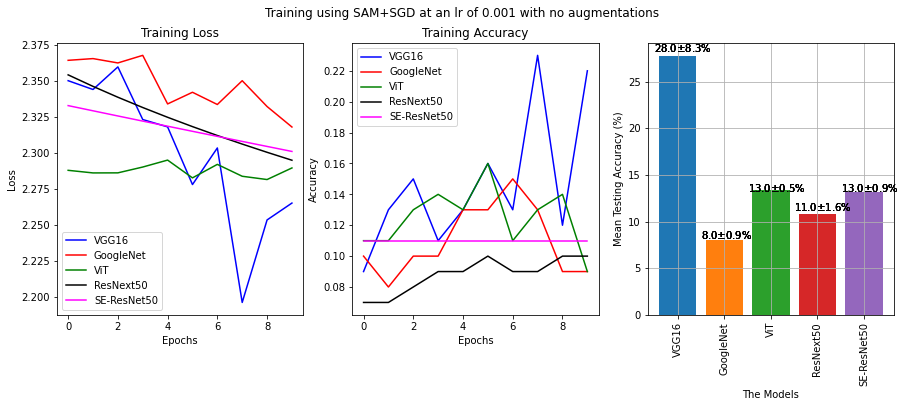

In [ ]:

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(15,5))
for t in range(len(trained_models)):
  
  plt.suptitle(f"Training using SAM+SGD at an lr of {learning_rate} with no augmentations")
  plt.subplot(1,3,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.title("Training Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(schemes)
  plt.subplot(1,3,2)
  plt.plot(train_acc[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(schemes)
  plt.subplot(1,3,3)
  
  for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    #print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")
    plt.bar(schemes[s],accs[s].mean())
    plt.xlabel("The Models")
    plt.ylabel("Mean Testing Accuracy (%)")
    plt.xticks(rotation="vertical")
    plt.grid(True)
    plt.text(s-0.5,np.round(accs[s].mean())+0.2,f"{str(np.round(accs[s].mean()))}$\pm${str(np.round(accs[s].std(),decimals=1))}%")
for s in range(len(schemes)):
    accs[s] = np.array(accs[s])
    print(f"Acc over 3 instances for {schemes[s]} is: {accs[s].mean():.3f} +- {accs[s].std():.3f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


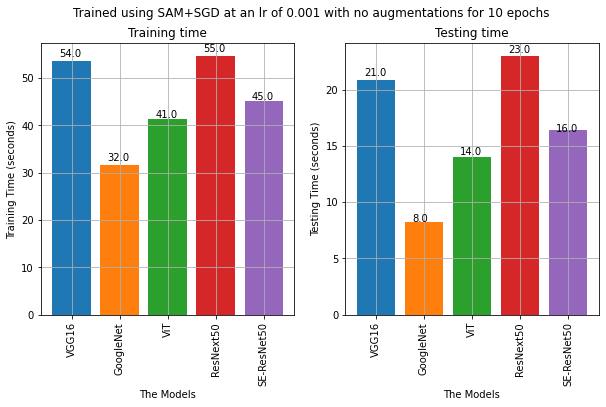

In [ ]:
plt.figure(figsize=(10,5))
for t in range(len(trained_models)):
  plt.subplot(1,2,1)
  plt.bar(schemes[t], runtime_train[t])
  plt.suptitle(f"Trained using SAM+SGD at an lr of {learning_rate} with no augmentations for {epoch+1} epochs")
  plt.title(f"Training time")
  plt.xlabel("The Models")
  plt.ylabel("Training Time (seconds)")
  plt.grid(True)
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_train[t])+0.5,f"{str(np.round(np.array(runtime_train[t]).mean()))}")
  plt.subplot(1,2,2)
    
  plt.bar(schemes[t], runtime_test[t])
  plt.title(f"Testing time")
  plt.xlabel("The Models")
  plt.ylabel("Testing Time (seconds)")
  plt.xticks(rotation="vertical")
  plt.text(t-0.25,np.round(runtime_test[t])+0.25,f"{str(np.round(np.array(runtime_test[t]).mean()))}")
  plt.grid(True)